# PREP

In [1]:
import os
import numpy as np
import math
import pandas as pd
import re
from functools import reduce
from collections import OrderedDict
from itertools import chain
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import (
    classification_report, 
    confusion_matrix, 
    multilabel_confusion_matrix,
    ConfusionMatrixDisplay, 
    accuracy_score
)
from wildlifeml.utils.io import (
    load_csv, 
    load_json, 
    load_pickle,
)

2023-07-18 07:50:43.466716: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1
2023-07-18 07:50:45.586859: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2023-07-18 07:50:45.586964: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2023-07-18 07:50:45.672901: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:18:00.0 name: GeForce RTX 2080 Ti computeCapability: 7.5
coreClock: 1.545GHz coreCount: 68 deviceMemorySize: 10.76GiB deviceMemoryBandwidth: 573.69GiB/s
2023-07-18 07:50:45.673671: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 1 with properties: 
pciBusID: 0000:3b:00.0 name: GeForce RTX 2080 Ti computeCapability: 7.5
coreClock: 1.545GHz coreCount: 68 deviceMemorySize: 10.76GiB deviceMemoryBandwidth: 573.69GiB/s
2023-

## SET MD4 OR MD5 / RESULTDIR

In [155]:
# REPODIR = '/home/lisa-wm/Documents/1_work/1_research/repos/wildlife-experiments'
REPODIR = '/home/wimmerl/projects/wildlife-experiments/'
RESULTDIR = os.path.join(REPODIR, 'results', 'channel_islands')  #, 'channel_islands'
DATADIR = os.path.join(REPODIR, 'data', 'channel_islands')
LABEL_MAP = load_json(os.path.join(DATADIR, 'label_map.json'))
EMPTY_CLASS = LABEL_MAP.get('empty') or 0

# SUFFIX_PKL = '.pkl'
# SUFFIX = ''
# OUR_THRESH = 0.5
SUFFIX_PKL = '_md5.pkl'
SUFFIX = 'md5'
OUR_THRESH = 0.1

In [156]:
CFG = load_json(os.path.join(REPODIR, 'configs/cfg.json'))
CONFMAT_ARGS = {
    'normalize': 'true',
    'values_format': '.2f',
    'display_labels': list(LABEL_MAP.keys()),
    'xticks_rotation': 45,
    'colorbar': False,
    'cmap': 'Blues',
}
CONFMAT_PLT_ARGS = {
    'figure.figsize': (6, 6),
    'font.size': 16,
    'xtick.labelsize': 16,
    'ytick.labelsize': 16,
    'xtick.alignment': 'right'
}
THRESHOLDS = [0.1, 0.3, 0.5, 0.7, 0.9]
ITERATIONS = list(range(8))[1:]
RANDOM_SEEDS = ['123', '456', '789']

## DATA

In [157]:
FILES_INSAMPLE = [
    [
        os.path.join(RESULTDIR, 'passive', t, f) for f in os.listdir(os.path.join(RESULTDIR, 'passive', t)) 
        if re.search(r'(insample_test_)+(\d+)' + re.escape(SUFFIX_PKL), f)
    ] 
    for t in [str(int(100 * ts)) for ts in THRESHOLDS]
]
FILES_OOSAMPLE = [
    os.path.join(RESULTDIR, 'passive', str(int(100 * OUR_THRESH)), f) 
    for f in os.listdir(os.path.join(RESULTDIR, 'passive', str(int(100 * OUR_THRESH)))) 
    if re.search(r'(oosample_)+(\d+)' + re.escape(SUFFIX_PKL), f)
]
FILES_ACTIVE_OPTIMAL = [
    os.path.join(RESULTDIR, 'active', 'optimal', f) 
    for f in os.listdir(os.path.join(RESULTDIR, 'active', 'optimal'))
    if re.search(r'(active_optimal_)+(\d+)' + re.escape(SUFFIX_PKL), f)
]
FILES_ACTIVE_COLDSTART = [
    os.path.join(RESULTDIR, 'active', 'coldstart', 'entropy', rs) for rs in RANDOM_SEEDS
]
FILES_ACTIVE_WARMSTART = [
    os.path.join(RESULTDIR, 'active', 'warmstart', 'entropy', rs) for rs in RANDOM_SEEDS
]

In [8]:
# RESULT_FILE = {**RESULTS_INSAMPLE_TEST_01, **RESULTS_INSAMPLE_TEST_05}
PREDS = 'preds_imgs_ppl'
TRUTH = 'truth_imgs_ppl'

In [9]:
def sort_results(dict_preds, truth):
    ordered_dict = {k: dict_preds[k] for k in sorted(list(dict_preds.keys()))}
    ordered_array = np.concatenate([x.reshape(1, len(LABEL_MAP)) for x in list(ordered_dict.values())])
    ordered_list = [truth[k] for k in [list(dict_preds.keys()).index(i) for i in sorted(list(dict_preds.keys()))]]
    return ordered_array, ordered_list

# IN-SAMPLE

## PERFORMANCE ACROSS THRESHOLDS ON TEST

Using varying thresholds for the MD, how well is our pipeline able to 1) classify images overall, 2) detect empty images correctly?

In [184]:
rows_multiclass_avg, rows_multiclass_se = [], []
rows_empty_avg, rows_empty_se = [], []

for idx, t in enumerate(THRESHOLDS):
    
    results_t = [f for f in FILES_INSAMPLE[idx]]
    accs, precs, recs, fones = [], [], [], []
    accs_empty, precs_empty, recs_empty, fones_empty = [], [], [], []
    precs_nonempty, recs_nonempty, fones_nonempty = [], [], []
    
    for rt in results_t:
        
        r = load_pickle(rt)
        preds_imgs_ppl_t, truth_imgs_ppl_t = sort_results(r[PREDS], r[TRUTH])
        y_true = truth_imgs_ppl_t
        y_pred = [np.argmax(v) for v in preds_imgs_ppl_t]
        print(LABEL_MAP.keys())
        print(set(y_true))
        report = classification_report(
            y_true=y_true, 
            y_pred=y_pred,
            target_names=list(LABEL_MAP.keys()),
            zero_division=0,
            output_dict=True,
        )
        
        accs.append(report['accuracy'])
        precs.append(report['weighted avg']['precision'])
        recs.append(report['weighted avg']['recall'])
        fones.append(report['weighted avg']['f1-score'])
        
        conf_empty = multilabel_confusion_matrix(y_true, y_pred, labels=[EMPTY_CLASS])
        tn, fp, fn, tp = conf_empty.ravel()
        accs_empty.append((tn + tp) / (tn + fp + fn + tp))
#         precs_empty.append(report['empty']['precision'])
#         recs_empty.append(report['empty']['recall'])
#         fones_empty.append(report['empty']['f1-score'])
        precs_empty.append(report['0.0']['precision'])
        recs_empty.append(report['0.0']['recall'])
        fones_empty.append(report['0.0']['f1-score'])
        precs_nonempty.append(tn / (tn + fn))
        recs_nonempty.append(tn / (tn + fp))
        fones_nonempty.append(2 * tn / (2 * tn + fn + fp))
        
    accs = np.array(accs)
    precs = np.array(precs)
    recs = np.array(recs)
    fones = np.array(fones)
    rows_multiclass_avg_t = [t]
    rows_multiclass_avg_t.extend(
        [np.round(x, 3) for x in [np.mean(accs), np.mean(precs), np.mean(recs), np.mean(fones)]]
    )
    rows_multiclass_avg.append(rows_multiclass_avg_t)
    rows_multiclass_se_t = [t]
    rows_multiclass_se_t.extend(
        [
            np.round(x, 3) for x in [
                np.std(accs) / math.sqrt(len(accs)),
                np.std(precs) / math.sqrt(len(precs)),
                np.std(recs) / math.sqrt(len(recs)),
                np.std(fones) / math.sqrt(len(fones))
            ]
            
        ]
        
    )
    rows_multiclass_se.append(rows_multiclass_se_t)
    accs_empty = np.array(accs_empty)
    precs_empty = np.array(precs_empty)
    recs_empty = np.array(recs_empty)
    fones_empty = np.array(fones_empty)
    precs_nonempty = np.array(precs_nonempty)
    recs_nonempty = np.array(recs_nonempty)
    fones_nonempty = np.array(fones_nonempty)
    rows_empty_avg_t = [t]
    rows_empty_avg_t.extend(
        [
            np.round(x, 3) for x in [
                np.mean(accs_empty), 
                np.mean(precs_empty), 
                np.mean(recs_empty), 
                np.mean(fones_empty),
                np.mean(precs_nonempty), 
                np.mean(recs_nonempty), 
                np.mean(fones_nonempty)                
            ]
        ]
    )
    rows_empty_avg.append(rows_empty_avg_t)
    rows_empty_se_t = [t]
    rows_empty_se_t.extend(
        [
            np.round(x, 3) for x in [
                np.std(accs_empty) / math.sqrt(len(accs_empty)),
                np.std(precs_empty) / math.sqrt(len(precs_empty)),
                np.std(recs_empty) / math.sqrt(len(recs_empty)),
                np.std(fones_empty) / math.sqrt(len(fones_empty)),
                np.std(precs_empty) / math.sqrt(len(precs_nonempty)),
                np.std(recs_empty) / math.sqrt(len(recs_nonempty)),
                np.std(fones_empty) / math.sqrt(len(fones_nonempty))
            ]
            
        ]
        
    )
    rows_empty_se.append(rows_empty_se_t)
COLNAMES = ['threshold', 'acc', 'prec', 'rec', 'fone']
COLNAMES_EMPTY = ['threshold', 'acc', 'prec', 'rec', 'fone', 'prec_ne', 'rec_ne', 'fone_ne']
df_ins_multiclass_avg = pd.DataFrame(rows_multiclass_avg, columns=COLNAMES)
df_ins_multiclass_se = pd.DataFrame(rows_multiclass_se, columns=COLNAMES)
df_ins_empty_avg = pd.DataFrame(rows_empty_avg, columns=COLNAMES_EMPTY)
df_ins_empty_se = pd.DataFrame(rows_empty_se, columns=COLNAMES_EMPTY)

dict_keys(['0', '1', '2', '3', '4', '5', '6'])
{0.0, 2.0, 3.0, 4.0, 5.0, 6.0}


ValueError: Number of classes, 6, does not match size of target_names, 7. Try specifying the labels parameter

In [160]:
df_ins_multiclass_avg  # Table 3

,threshold,acc,prec,rec,fone
0,0.1,0.984,0.983,0.984,0.983
1,0.3,0.983,0.982,0.983,0.982
2,0.5,0.978,0.977,0.978,0.976
3,0.7,0.957,0.958,0.957,0.951
4,0.9,0.905,0.914,0.905,0.883


In [161]:
df_ins_empty_avg  # Table 2

,threshold,acc,prec,rec,fone,prec_ne,rec_ne,fone_ne
0,0.1,0.986,0.987,0.997,0.992,0.985,0.944,0.964
1,0.3,0.986,0.986,0.997,0.991,0.985,0.940,0.962
2,0.5,0.979,0.977,0.998,0.987,0.990,0.902,0.944
3,0.7,0.958,0.952,0.999,0.975,0.993,0.792,0.881
4,0.9,0.906,0.895,1.000,0.945,0.998,0.517,0.681


In [162]:
df_ins_multiclass_avg.to_csv(os.path.join(RESULTDIR, 'passive', f'insample{SUFFIX}.csv'))
df_ins_empty_avg.to_csv(os.path.join(RESULTDIR, 'passive', f'insample_empty{SUFFIX}.csv'))

## PERFORMANCE

In [166]:
reports, conf_matrices = [], []
y_trues, y_preds = np.empty(0), np.empty(0)
for r in [load_pickle(f) for f in FILES_INSAMPLE[1]]:
    preds_imgs_ppl_t, truth_imgs_ppl_t = sort_results(r['preds_imgs_ppl'], r['truth_imgs_ppl'])
    y_trues = np.concatenate((y_trues, truth_imgs_ppl_t))
    y_preds = np.concatenate((y_preds, [np.argmax(v) for v in preds_imgs_ppl_t]))
print(  # Figure 3
    classification_report(
        y_true=np.array(y_trues), 
        y_pred=np.array(y_preds),
#         target_names=list(LABEL_MAP.keys()),
    )
)

              precision    recall  f1-score   support

         0.0       0.99      1.00      0.99     13392
         2.0       0.97      0.96      0.97      2457
         3.0       0.92      0.92      0.92        48
         4.0       0.96      0.87      0.91       621
         5.0       0.93      0.50      0.65       102
         6.0       0.00      0.00      0.00        12

    accuracy                           0.98     16632
   macro avg       0.79      0.71      0.74     16632
weighted avg       0.98      0.98      0.98     16632



/home/wimmerl/miniconda2/envs/wildlife/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/wimmerl/miniconda2/envs/wildlife/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/wimmerl/miniconda2/envs/wildlife/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_sta

ValueError: The number of FixedLocator locations (6), usually from a call to set_ticks, does not match the number of ticklabels (7).

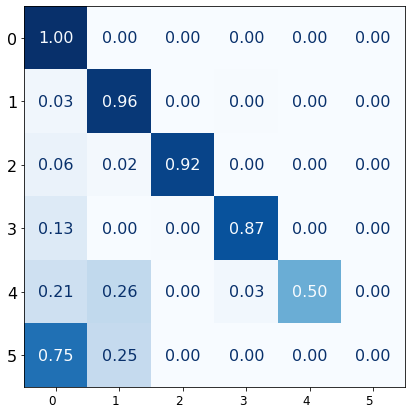

In [165]:
ConfusionMatrixDisplay.from_predictions(y_true=np.array(y_trues), y_pred=np.array(y_preds), **CONFMAT_ARGS)
plt.rcParams.update(CONFMAT_PLT_ARGS)
plt.savefig(f'figures/cm_insample{SUFFIX}.eps', bbox_inches='tight')
plt.savefig(f'figures/cm_insample{SUFFIX}.png', bbox_inches='tight')

# OUT-OF-SAMPLE

## PERFORMANCE

In [168]:
rows_multiclass_avg, rows_multiclass_se = [], []
accs, precs, recs, fones = [], [], [], []

for r in [f for f in FILES_OOSAMPLE]:
    r = load_pickle(r)
    preds_imgs_ppl, truth_imgs_ppl = sort_results(r[PREDS], r[TRUTH])
    y_true = truth_imgs_ppl
    y_pred = [np.argmax(v) for v in preds_imgs_ppl]
    report = classification_report(
        y_true=y_true, 
        y_pred=y_pred,
#         target_names=list(LABEL_MAP.keys()),
        zero_division=0,
        output_dict=True,
    )
    accs.append(report['accuracy'])
    precs.append(report['weighted avg']['precision'])
    recs.append(report['weighted avg']['recall'])
    fones.append(report['weighted avg']['f1-score'])
accs = np.array(accs)
precs = np.array(precs)
recs = np.array(recs)
fones = np.array(fones)
rows_multiclass_avg.append([np.round(x, 3) for x in [np.mean(accs), np.mean(precs), np.mean(recs), np.mean(fones)]])
rows_multiclass_se.append(
    [
        np.round(x, 3) for x in [
            np.std(accs) / math.sqrt(len(accs)),
            np.std(precs) / math.sqrt(len(precs)),
            np.std(recs) / math.sqrt(len(recs)),
            np.std(fones) / math.sqrt(len(fones))
        ]
        
    ]

)
COLNAMES = ['acc', 'prec', 'rec', 'fone']
df_oos_multiclass_avg = pd.DataFrame(rows_multiclass_avg, columns=COLNAMES)
df_oos_multiclass_se = pd.DataFrame(rows_multiclass_se, columns=COLNAMES)

In [169]:
acc_al_lower_limit, rec_al_lower_limit = rows_multiclass_avg[0][0], rows_multiclass_avg[0][1]

In [170]:
df_multiclass_avg = pd.concat(
    [df_ins_multiclass_avg.loc[df_ins_multiclass_avg['threshold'] == OUR_THRESH], df_oos_multiclass_avg]
)
df_multiclass_avg.index = ['ins', 'oos']

In [171]:
df_multiclass_se = pd.concat(
    [df_ins_multiclass_se.loc[df_ins_multiclass_se['threshold'] == OUR_THRESH], df_oos_multiclass_se]
)
df_multiclass_se.index = ['ins', 'oos']

In [172]:
df_multiclass_avg.drop(['threshold'], axis=1).to_csv(os.path.join(RESULTDIR, 'passive', f'oosample{SUFFIX}.csv'))

In [173]:
reports, conf_matrices = [], []
y_trues, y_preds = np.empty(0), np.empty(0)
for r in [load_pickle(f) for f in FILES_OOSAMPLE]:
    preds_imgs_ppl_t, truth_imgs_ppl_t = sort_results(r['preds_imgs_ppl'], r['truth_imgs_ppl'])
    y_trues = np.concatenate((y_trues, truth_imgs_ppl_t))
    y_preds = np.concatenate((y_preds, [np.argmax(v) for v in preds_imgs_ppl_t]))

ValueError: The number of FixedLocator locations (5), usually from a call to set_ticks, does not match the number of ticklabels (7).

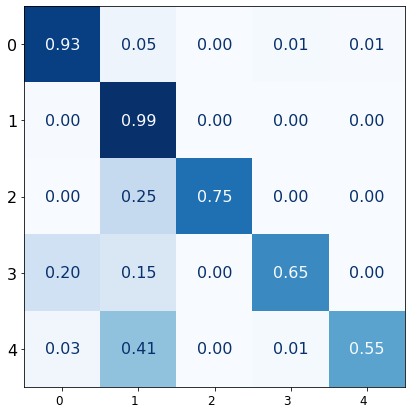

In [174]:
ConfusionMatrixDisplay.from_predictions(y_true=np.array(y_trues), y_pred=np.array(y_preds), **CONFMAT_ARGS)
plt.rcParams.update(CONFMAT_PLT_ARGS)
plt.savefig(f'figures/cm_oosample{SUFFIX}.eps', bbox_inches='tight')
plt.savefig(f'figures/cm_oosample{SUFFIX}.png', bbox_inches='tight')

## ACTIVE LEARNING

In [175]:
reports, conf_matrices = [], []
y_trues, y_preds = np.empty(0), np.empty(0)
for r in [load_pickle(f) for f in FILES_ACTIVE_OPTIMAL]:
    preds_imgs_ppl_t, truth_imgs_ppl_t = sort_results(r['preds_imgs_ppl'], r['truth_imgs_ppl'])
    y_trues = np.concatenate((y_trues, truth_imgs_ppl_t))
    y_preds = np.concatenate((y_preds, [np.argmax(v) for v in preds_imgs_ppl_t]))
report_dict = classification_report(
    y_true=np.array(y_trues), 
    y_pred=np.array(y_preds),
    target_names=list(LABEL_MAP.keys()),
    output_dict=True,
    zero_division=0
)
acc_al_upper_limit, rec_al_upper_limit = report_dict['accuracy'], report_dict['weighted avg']['precision']

ValueError: Number of classes, 5, does not match size of target_names, 7. Try specifying the labels parameter

In [176]:
print(  # Figure 5
    classification_report(
        y_true=np.array(y_trues), 
        y_pred=np.array(y_preds),
        target_names=list(LABEL_MAP.keys()),
        zero_division=0,
        output_dict=True,
    )

) 

ValueError: Number of classes, 5, does not match size of target_names, 7. Try specifying the labels parameter

In [177]:
# compute relative sample size per iteration (sizes hard-coded for training)
n_obs = len(y_trues)
init_batches = [2**x for x in range(7, 13)] # !!
batch_sizes = init_batches + [n_obs - sum(init_batches)]
batch_sizes_cs = np.cumsum([x / n_obs for x in batch_sizes])

In [178]:
batch_sizes

[128, 256, 512, 1024, 2048, 4096, 6552]

In [179]:
batch_sizes_cs

array([0.00875753, 0.02627258, 0.06130268, 0.13136289, 0.27148331,
       0.55172414, 1.        ])

In [180]:
ITERATION_EXTRACT = 4

In [182]:
acc_coldstart_avg, rec_coldstart_avg = [], []
acc_coldstart_se, rec_coldstart_se = [], []
acc_warmstart_avg, rec_warmstart_avg = [], []
acc_warmstart_se, rec_warmstart_se = [], []

for i in ITERATIONS: # !!
    acc_coldstart, rec_coldstart = [], []
    acc_warmstart, rec_warmstart = [], []
    y_trues, y_preds = np.empty(0), np.empty(0)
    for r in [
        load_pickle(f) for f in [
            os.path.join(FILES_ACTIVE_COLDSTART[idx], f'results_iteration_{i}.pkl') 
            for idx, _ in enumerate(RANDOM_SEEDS)
        ]
    ]:
        preds_imgs_ppl, truth_imgs_ppl = sort_results(r['preds_imgs_ppl'], r['truth_imgs_ppl'])
        y_true = truth_imgs_ppl
        y_pred = [np.argmax(v) for v in preds_imgs_ppl]
        report_dict_cs = classification_report(
            y_true=y_true, 
            y_pred=y_pred,
            target_names=list(LABEL_MAP.keys()),
            output_dict=True,
            zero_division=0
        )
        acc_coldstart.append(report_dict_cs['accuracy'])
        rec_coldstart.append(report_dict_cs['weighted avg']['precision'])
        if i == ITERATION_EXTRACT:
            y_trues = np.concatenate((y_trues, y_true))
            y_preds = np.concatenate((y_preds, y_pred))
    if i == ITERATION_EXTRACT:
        ConfusionMatrixDisplay.from_predictions(y_true=np.array(y_trues), y_pred=np.array(y_preds), **CONFMAT_ARGS)
        plt.rcParams.update(CONFMAT_PLT_ARGS)
        plt.savefig(f'figures/cm_active{SUFFIX}.eps', bbox_inches='tight')
        plt.savefig(f'figures/cm_active{SUFFIX}.png', bbox_inches='tight')
        print(
            classification_report(
                y_true=y_trues, 
                y_pred=y_preds,
                target_names=list(LABEL_MAP.keys()),
                output_dict=True,
                zero_division=0
            )
        )
        df = pd.DataFrame(
            [[report['accuracy'], report['weighted avg']['precision'], report['weighted avg']['f1-score']]], 
            columns=['acc', 'prec', 'fone']
        )
        df.to_csv(os.path.join(RESULTDIR, 'active', f'iteration_{ITERATION_EXTRACT}{SUFFIX}.csv'))
    for r in [
        load_pickle(f) for f in [
            os.path.join(FILES_ACTIVE_WARMSTART[idx], f'results_iteration_{i}.pkl') 
            for idx, _ in enumerate(RANDOM_SEEDS)
        ]
    ]:
        preds_imgs_ppl, truth_imgs_ppl = sort_results(r['preds_imgs_ppl'], r['truth_imgs_ppl'])
        y_true = truth_imgs_ppl
        y_pred = [np.argmax(v) for v in preds_imgs_ppl]
        report_dict_ws = classification_report(
            y_true=y_true, 
            y_pred=y_pred,
            target_names=list(LABEL_MAP.keys()),
            output_dict=True,
            zero_division=0
        )
        acc_warmstart.append(report_dict_ws['accuracy'])
        rec_warmstart.append(report_dict_ws['weighted avg']['precision'])
    acc_coldstart = np.array(acc_coldstart)
    rec_coldstart = np.array(rec_coldstart)
    acc_coldstart_avg.append(np.mean(acc_coldstart))
    rec_coldstart_avg.append(np.mean(rec_coldstart))
    acc_coldstart_se.append(np.std(acc_coldstart) / math.sqrt(len(acc_coldstart)))
    rec_coldstart_se.append(np.std(rec_coldstart) / math.sqrt(len(rec_coldstart)))
    acc_warmstart = np.array(acc_warmstart)
    rec_warmstart = np.array(rec_warmstart)
    acc_warmstart_avg.append(np.mean(acc_warmstart))
    rec_warmstart_avg.append(np.mean(rec_warmstart))
    acc_warmstart_se.append(np.std(acc_warmstart) / math.sqrt(len(acc_warmstart)))
    rec_warmstart_se.append(np.std(rec_warmstart) / math.sqrt(len(rec_warmstart)))        

ValueError: Number of classes, 5, does not match size of target_names, 7. Try specifying the labels parameter

In [149]:
acc_coldstart_avg[-1] = acc_al_upper_limit
acc_warmstart_avg[-1] = acc_al_upper_limit
acc_coldstart_se[-1] = 0
acc_warmstart_se[-1] = 0

In [69]:
# acc_coldstart_avg += [acc_al_upper_limit]
# acc_warmstart_avg += [acc_al_upper_limit]
# acc_coldstart_se += [0]
# acc_warmstart_se += [0]

In [150]:
# create data for plot
al_perf_acc = {
    'relative_size': batch_sizes_cs,
    'acc_lower_limit': [acc_al_lower_limit for _ in range(len(acc_coldstart_avg))],
    'acc_upper_limit': [acc_al_upper_limit for _ in range(len(acc_coldstart_avg))],
    'acc_coldstart': acc_coldstart_avg,
    'se_coldstart': acc_coldstart_se,
    'acc_warmstart': acc_warmstart_avg,
    'se_warmstart': acc_warmstart_se,
}
al_perf_rec = {
    'relative_size': batch_sizes_cs,
    'rec_lower_limit': [rec_al_lower_limit for _ in range(len(acc_coldstart_avg))],
    'rec_upper_limit': [rec_al_upper_limit for _ in range(len(acc_coldstart_avg))],
    'rec_coldstart': rec_coldstart_avg,
    'rec_coldstart_se': rec_coldstart_se,
    'rec_warmstart': rec_warmstart
}

In [152]:
al_perf_acc_pd = pd.DataFrame(al_perf_acc)
# al_perf_rec_pd = pd.DataFrame(al_perf_rec)

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


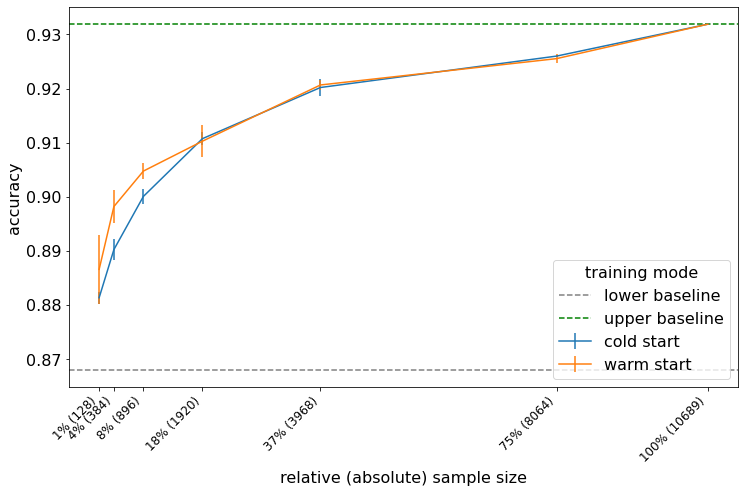

In [154]:
fig, ax = plt.subplots()
ax.errorbar(al_perf_acc_pd['relative_size'], al_perf_acc_pd['acc_coldstart'], al_perf_acc_pd['se_coldstart'])
ax.errorbar(al_perf_acc_pd['relative_size'], al_perf_acc_pd['acc_warmstart'], al_perf_acc_pd['se_warmstart'])
ax.set_xlabel('relative (absolute) sample size')
ax.set_xticks(al_perf_acc_pd['relative_size'])
dataset_sizes = [
    f' {round(i * 100)}% ({round(j)})' for i, j in zip(al_perf_acc_pd['relative_size'], np.cumsum(batch_sizes))
]
ax.set_xticklabels(dataset_sizes, rotation=45, ha='right')
ax.set_ylabel('accuracy')
ax.axhline(acc_al_lower_limit,color='gray',ls='--')
ax.axhline(acc_al_upper_limit,color='green',ls='--')
ax.legend(
    title='training mode', 
    loc='lower right', 
    labels=['lower baseline', 'upper baseline', 'cold start', 'warm start']
)
plt_args = {
    'figure.figsize': (12, 7),
    'font.size': 16,
    'xtick.labelsize': 12,
    'ytick.labelsize': 16,
    'xtick.alignment': 'right'
}
plt.rcParams.update(plt_args)
plt.savefig(f'figures/active_learning{SUFFIX}.eps', bbox_inches='tight')
plt.savefig(f'figures/active_learning{SUFFIX}.png', bbox_inches='tight')